# CNN Image Classifier

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import os

2025-04-11 07:23:31.362424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744377811.382538 1108258 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744377811.387975 1108258 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744377811.406572 1108258 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744377811.406613 1108258 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744377811.406617 1108258 computation_placer.cc:177] computation placer alr

## Hyperparameters

In [2]:
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
LEARNING_RATE = 0.00001
EPOCHS = 100

## Dataset

The used [Animal Image Dataset](https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals). It was split into a training and testing set at an 80 to 20 ratio using [this script](./split.ipynb)

In [3]:
dataset_dir = os.path.join('datasets', 'animals')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

We build the image loaders. For training we also apply data augmentation through rotation, width shifting, zoom in and horizontal flipping. The images are also rescaled so taht the pixel values are between 0 and 1 instead of 0 to 255

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode="binary",
)

classes = len(train_generator.class_indices)

Found 4320 images belonging to 90 classes.


## Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout,
    BatchNormalization, 
)
from tensorflow.keras.applications.vgg16 import VGG16

model = Sequential()

vgg16_layer = VGG16(weights="imagenet", include_top=False)
vgg16_layer.trainable = False

model.add(Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(vgg16_layer)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(classes, activation="softmax"))

model.summary()

I0000 00:00:1744377814.221198 1108258 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │        92,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,246,170 (92.49 MB)

 Trainable params: 9,531,482 (36.36 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
    ],
)

In [7]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "checkpoints/animal_model_4_{epoch:02d}.keras",
        save_freq=len(train_generator) * 5, # every 5 epochs
    ),
]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS*2,
    callbacks=callbacks,
)

/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1744377816.909484 1108584 service.cc:152] XLA service 0x744e9800fce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744377816.909502 1108584 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-11 07:23:36.936052: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744377817.203204 1108584 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-11 07:23:38.028413: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1463', 84 bytes spill stores, 84 bytes spill loads

2025-04-11 07:23:38.278665: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

  1/135 ━━━━━━━━━━━━━━━━━━━━ 14:46 7s/step - accuracy: 0.0000e+00 - loss: 5.1452

I0000 00:00:1744377822.408458 1108584 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.0090 - loss: 4.8096
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.0164 - loss: 4.6069
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.0212 - loss: 4.5123
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.0243 - loss: 4.4469
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.0391 - loss: 4.3965
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.0384 - loss: 4.3679
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.0521 - loss: 4.2980
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.0623 - loss: 4.2619
Epoch 9/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.0688 - loss: 4.2004
Epoch 10/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.0889 - loss: 4.1378
Epoch 11/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.0939 - loss: 4.0931
Epoch 12/100
135/135

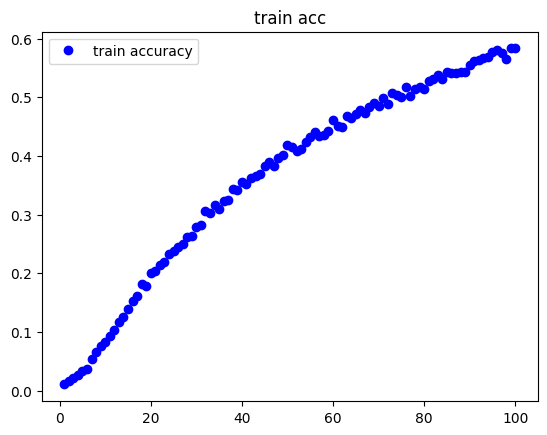

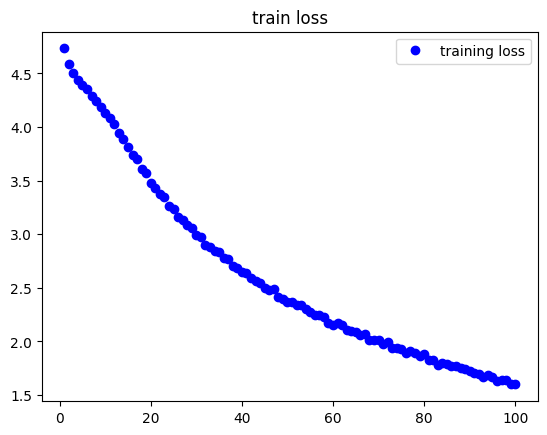

In [9]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(1, len(acc) + 1)

plt.plot(epochs_range, acc, "bo", label="train accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, "bo", label="training loss")
plt.title("train loss")
plt.legend()

plt.show()

In [10]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

Found 1080 images belonging to 90 classes.


2025-04-11 08:00:29.264497: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 120 bytes spill stores, 120 bytes spill loads

2025-04-11 08:00:29.268892: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194_0', 468 bytes spill stores, 1028 bytes spill loads

2025-04-11 08:00:29.455297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 608 bytes spill stores, 608 bytes spill loads

2025-04-11 08:00:29.510537: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 488 bytes spill stores, 488 bytes spill loads

2025-04-11 08:00:29.990945: I ext

33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6063 - loss: 1.5458

2025-04-11 08:00:35.330094: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 4 bytes spill stores, 4 bytes spill loads

2025-04-11 08:00:35.537095: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 124 bytes spill stores, 124 bytes spill loads

2025-04-11 08:00:35.819503: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 212 bytes spill stores, 244 bytes spill loads

2025-04-11 08:00:35.890639: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194_0', 592 bytes spill stores, 1236 bytes spill loads

2025-04-11 08:00:36.151210: I externa

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - accuracy: 0.6070 - loss: 1.5424
Test accuracy: 0.6194444298744202
Test loss: 1.4870089292526245
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step


In [12]:
history2 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS*2,
    initial_epoch=EPOCHS,
    callbacks=callbacks,
)

Epoch 101/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.5811 - loss: 1.5862
Epoch 102/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.5907 - loss: 1.5928
Epoch 103/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.5785 - loss: 1.6180
Epoch 104/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.5983 - loss: 1.5423
Epoch 105/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.5692 - loss: 1.6230
Epoch 106/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.5873 - loss: 1.5665
Epoch 107/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.5925 - loss: 1.5449
Epoch 108/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.6010 - loss: 1.5609
Epoch 109/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.6124 - loss: 1.5008
Epoch 110/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.6042 - loss: 1.4870
Epoch 111/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.6231 - l

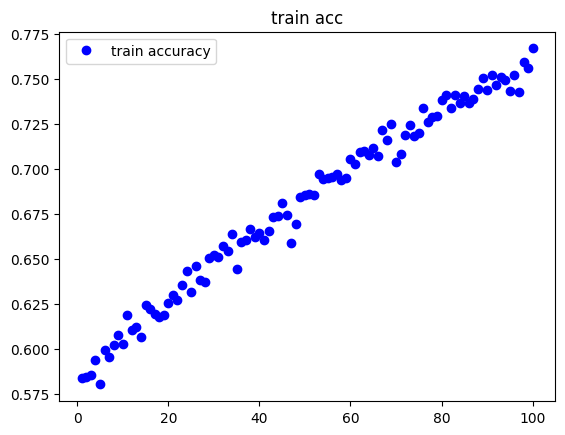

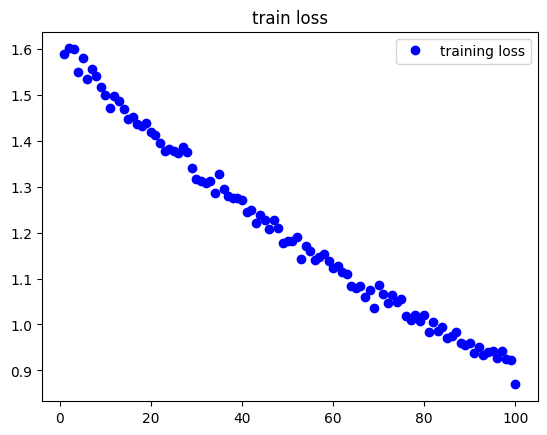

In [13]:
acc = history2.history['accuracy']

loss = history2.history['loss']

epochs_range = range(1, len(acc) + 1)

plt.plot(epochs_range, acc, "bo", label="train accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, "bo", label="training loss")
plt.title("train loss")
plt.legend()

plt.show()

In [14]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

Found 1080 images belonging to 90 classes.


/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.6779 - loss: 1.2807
Test accuracy: 0.6944444179534912
Test loss: 1.2065942287445068
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


Classification Report:
                precision    recall  f1-score   support

      antelope       0.58      0.58      0.58        12
        badger       0.67      0.50      0.57        12
           bat       0.64      0.75      0.69        12
          bear       0.50      0.50      0.50        12
           bee       0.83      0.83      0.83        12
        beetle       0.79      0.92      0.85        12
         bison       0.67      0.50      0.57        12
          boar       0.45      0.42      0.43        12
     butterfly       0.79      0.92      0.85        12
           cat       0.83      0.83      0.83        12
   caterpillar       0.70      0.58      0.64        12
    chimpanzee       0.75      0.75      0.75        12
     cockroach       0.90      0.75      0.82        12
           cow       0.53      0.67      0.59        12
        coyote       0.71      0.42      0.53        12
          crab       0.70      0.58      0.64        12
          crow       0.7

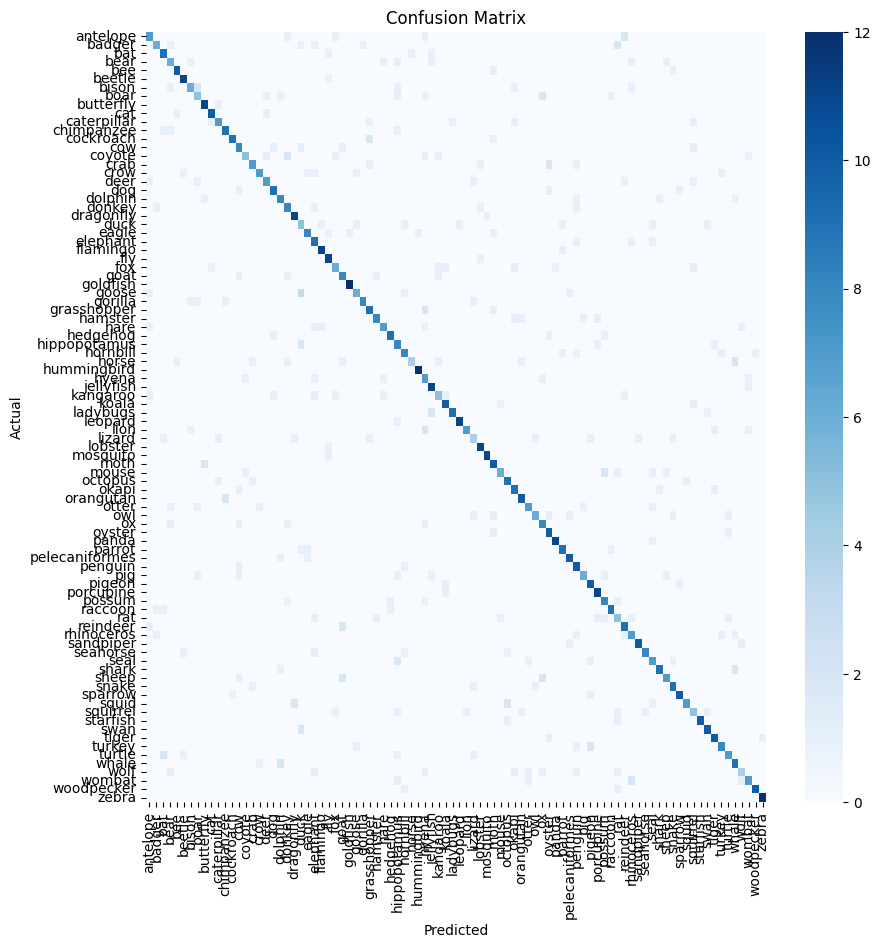

In [15]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_names = list(test_generator.class_indices.keys())

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
)


conf_matrix = confusion_matrix(y_true, y_pred)

print("Classification Report:")
print(report)

plt.figure(figsize=(10, 10))
sns.heatmap(
    conf_matrix,
    # annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    # xtickrotation=45,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
